In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=30

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\Potato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1500 files belonging to 3 classes.


In [6]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

47

(32, 256, 256, 3)
[2 2 0 1 0 2 0 2 2 2 2 1 2 0 2 1 1 1 0 2 1 2 2 1 1 0 2 1 0 1 2 2]


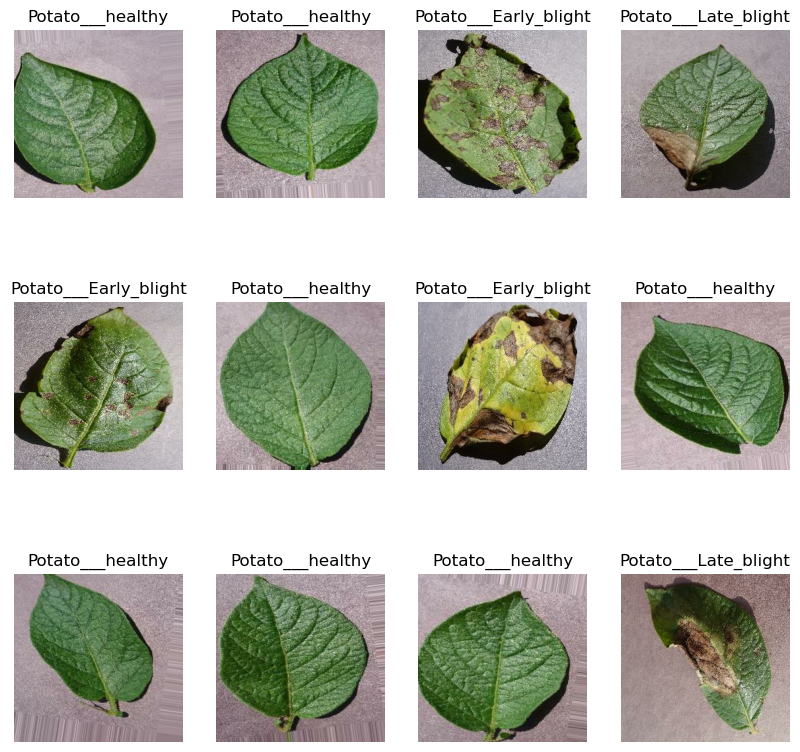

In [8]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [10]:
print(len(train_ds), len(val_ds), len(test_ds))

37 4 6


In [11]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [13]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [14]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/30
37/37 [==============================] - 52s 1s/step - loss: 1.0699 - accuracy: 0.3932 - val_loss: 0.8825 - val_accuracy: 0.6641
Epoch 2/30
37/37 [==============================] - 48s 1s/step - loss: 0.7031 - accuracy: 0.6720 - val_loss: 1.2720 - val_accuracy: 0.4766
Epoch 3/30
37/37 [==============================] - 47s 1s/step - loss: 0.5453 - accuracy: 0.7432 - val_loss: 0.6331 - val_accuracy: 0.7031
Epoch 4/30
37/37 [==============================] - 46s 1s/step - loss: 0.4245 - accuracy: 0.8237 - val_loss: 0.4989 - val_accuracy: 0.7891
Epoch 5/30
37/37 [==============================] - 45s 1s/step - loss: 0.3138 - accuracy: 0.8839 - val_loss: 0.2486 - val_accuracy: 0.8984
Epoch 6/30
37/37 [==============================] - 46s 1s/step - loss: 0.3393 - accuracy: 0.8585 - val_loss: 0.2939 - val_accuracy: 0.8984
Epoch 7/30
37/37 [==============================] - 46s 1s/step - loss: 0.2437 - accuracy: 0.9203 - val_loss: 0.3598 - val_accuracy: 0.8828
Epoch 8/30
37/37 [==

In [15]:
scores=model.evaluate(test_ds)
scores

6/6 [==============================] - 2s 228ms/step - loss: 0.7763 - accuracy: 0.8125


[0.7762865424156189, 0.8125]

In [16]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [17]:
history.history['loss']

[1.0698992013931274,
 0.7030559182167053,
 0.5452696681022644,
 0.4245392680168152,
 0.31384432315826416,
 0.33930784463882446,
 0.24368907511234283,
 0.23756907880306244,
 0.20282866060733795,
 0.12373485416173935,
 0.12094109505414963,
 0.07555565983057022,
 0.09242523461580276,
 0.08819307386875153,
 0.08008245378732681,
 0.2005830705165863,
 0.057294368743896484,
 0.07002206891775131,
 0.05716952309012413,
 0.16582880914211273,
 0.10185187309980392,
 0.055420517921447754,
 0.03566577285528183,
 0.06913486123085022,
 0.03556111082434654,
 0.045075442641973495,
 0.040682315826416016,
 0.02480912022292614,
 0.0244271419942379,
 0.08313814550638199]

In [18]:
history.history['accuracy']

[0.39322033524513245,
 0.6720339059829712,
 0.743220329284668,
 0.8237287998199463,
 0.8838983178138733,
 0.8584745526313782,
 0.9203389883041382,
 0.9127118587493896,
 0.9313559532165527,
 0.9610169529914856,
 0.9627118706703186,
 0.9737288355827332,
 0.9711864590644836,
 0.9728813767433167,
 0.9745762944221497,
 0.9330508708953857,
 0.9796609878540039,
 0.9745762944221497,
 0.9788135886192322,
 0.93813556432724,
 0.9711864590644836,
 0.9830508232116699,
 0.9864406585693359,
 0.9805084466934204,
 0.9872881174087524,
 0.9847457408905029,
 0.9855931997299194,
 0.993220329284668,
 0.991525411605835,
 0.9745762944221497]

In [19]:
history.history['val_loss']

[0.8825455904006958,
 1.2720160484313965,
 0.6330587863922119,
 0.4988817870616913,
 0.24862277507781982,
 0.2938740849494934,
 0.3597538471221924,
 0.4403291642665863,
 0.5688563585281372,
 0.26729556918144226,
 0.3640940487384796,
 0.5510835647583008,
 0.3423475921154022,
 0.7468516826629639,
 1.1312885284423828,
 0.15474697947502136,
 0.2089143991470337,
 0.5404529571533203,
 0.4993184208869934,
 0.5585207939147949,
 0.4926164448261261,
 0.29301717877388,
 0.7794253826141357,
 0.2560988962650299,
 0.2194761484861374,
 0.3920036852359772,
 0.2286822497844696,
 0.05246249586343765,
 0.7863507866859436,
 0.7665659189224243]

In [20]:
history.history['val_accuracy']

[0.6640625,
 0.4765625,
 0.703125,
 0.7890625,
 0.8984375,
 0.8984375,
 0.8828125,
 0.8671875,
 0.828125,
 0.921875,
 0.8984375,
 0.8671875,
 0.9375,
 0.8359375,
 0.7890625,
 0.9375,
 0.921875,
 0.859375,
 0.8828125,
 0.8359375,
 0.859375,
 0.9453125,
 0.84375,
 0.921875,
 0.9453125,
 0.8984375,
 0.9453125,
 0.9765625,
 0.859375,
 0.8046875]

In [21]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

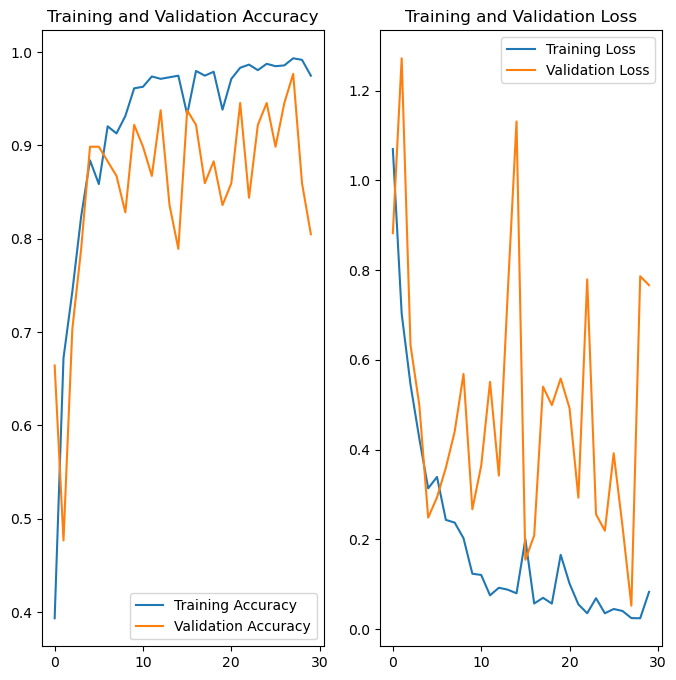

In [22]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [23]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(6):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 274ms/step


In [24]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 34ms/step


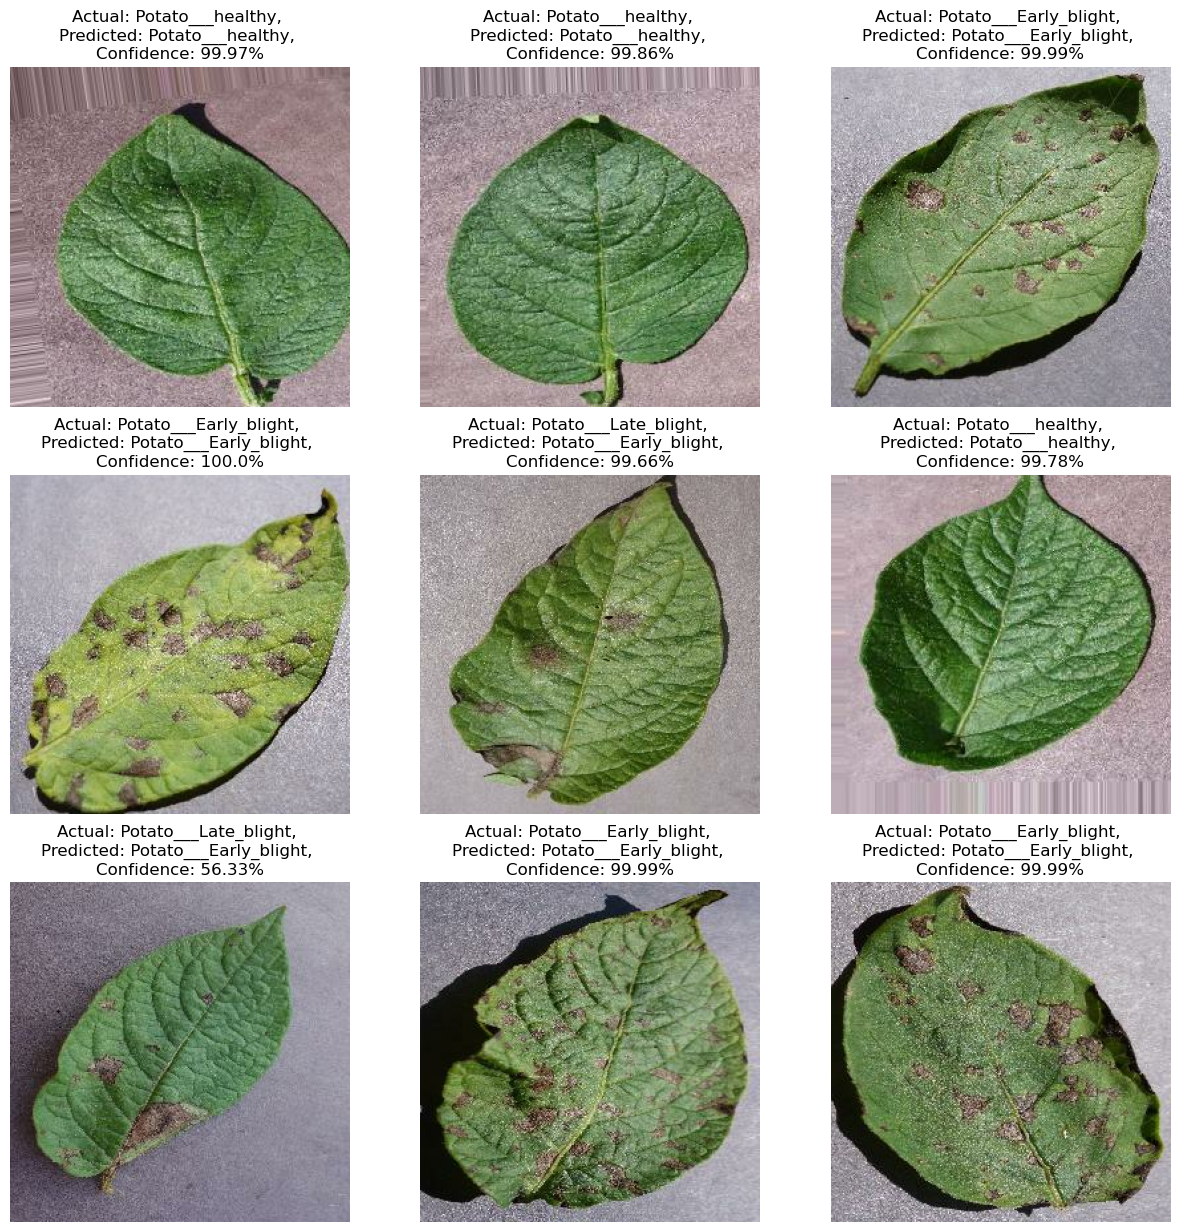

In [25]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [26]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.66      1.00      0.79        69
           1       1.00      0.44      0.61        64
           2       1.00      1.00      1.00        59

    accuracy                           0.81       192
   macro avg       0.89      0.81      0.80       192
weighted avg       0.88      0.81      0.80       192



In [27]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
cm

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[69,  0,  0],
       [36, 28,  0],
       [ 0,  0, 59]])>

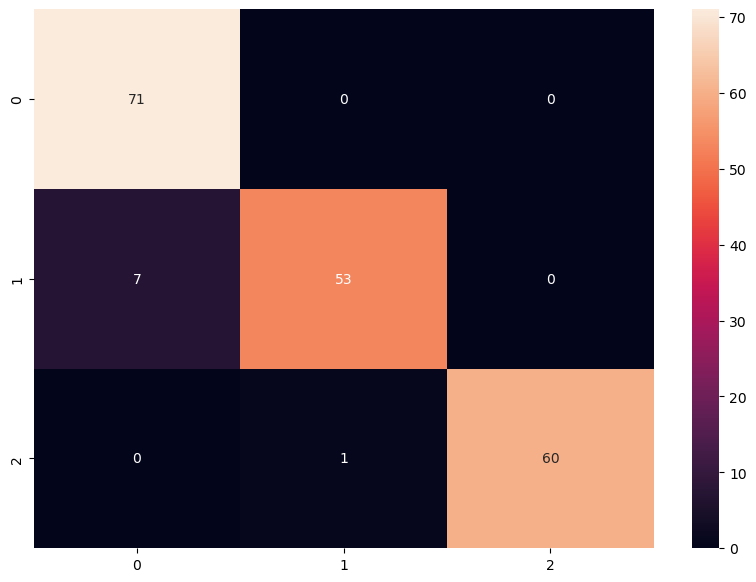

In [27]:
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [28]:
filename = "Model1-2-Epochs30.joblib"
joblib.dump(model, filename)

['Model1-2-Epochs30.joblib']